# 2D wave equation, direct problem
---

Consider the 2d wave
$$
u_{tt} = c^2(u_{xx} + u_{yy}), \ (x, y, t) \in [0, 1]\times [0, 1]\times [0, 1] 
$$
with ic
$$
u(x, y, 0) = J_0(\lambda_4 \sqrt{x^2+y^2}), \ \frac{\partial u}{\partial t}(x, y, 0) = 0,
$$
and bc
$$
u = 0.
$$

The analytic solution:
$$
u(x, y, t) = J_0(\lambda_4\sqrt{x^2+y^2})\cos(c\lambda_4 t),
$$
where $J_0$ is the Bessel function of the first kind, and $\lambda_4$ is its $4^{th}$ root.

--

Target: $c = 0.25$.

In [2]:
NAME = "2_direct_problem"

In [3]:
import jax, jax.nn
from jax import random
import jax.numpy as jnp
from jax.experimental import optimizers

import sys, os
sys.path.append("../../")
	
from Seismic_wave_inversion_PINN.data_utils import *

from collections import namedtuple

In [4]:
def siren_layer_params(key, scale, m, n):
	w_key, b_key = random.split(key)
	return random.uniform(w_key, (m, n), jnp.float32, minval = -scale, maxval = scale), jnp.zeros((n, ), jnp.float32)

def init_siren_params(key, layers, c0, w0, w1):
	keys = random.split(key, len(layers))
	return [siren_layer_params(keys[0], w0*jnp.sqrt(c0/layers[0]), layers[0], layers[1])] + \
			[siren_layer_params(k, jnp.sqrt(c0/m), m, n) for m, n, k in zip(layers[1:-2], layers[2:-1], keys[1:-2])] + \
			[siren_layer_params(keys[-1], w1*jnp.sqrt(c0/layers[-2]), layers[-2], layers[-1])]

layers = [3, 32, 32, 32, 32, 32, 32, 32, 32, 32, 1] # (x, z, t) -> p
c0 = 1.0
w0 = 5.0
w1 = 1.0
lambda_0 = 1e-10
direct_params = init_siren_params(random.PRNGKey(0), layers, c0, w0, w1)

# @jax.jit
# def scalar_direct_model(params, x, z, t):
# 	x_ = jnp.hstack([x, z, t])
# 	for w, b in params[:-1]:
# 		x_ = jnp.sin(jnp.dot(x_, w) + b)
# 	return jnp.sum(jnp.dot(x_, params[-1][0]) + params[-1][1])

# direct_model = jax.jit(jax.vmap(scalar_direct_model, in_axes = (None, 0, 0, 0)))

@jax.jit
def direct_model(params, xyt):
	for w, b in params[:-1]:
		xyt = jnp.tanh(jnp.dot(xyt, w) + b)
	return jnp.dot(xyt, params[-1][0]) + params[-1][1]

jacobian = lambda params, xyt: jax.jit(jax.vmap(jax.jacobian(direct_model, 1), (None, 0)))(params, xyt)
hessian = lambda params, xyt: jax.jit(jax.vmap(jax.hessian(direct_model, 1), (None, 0)))(params, xyt)

<IPython.core.display.Javascript object>


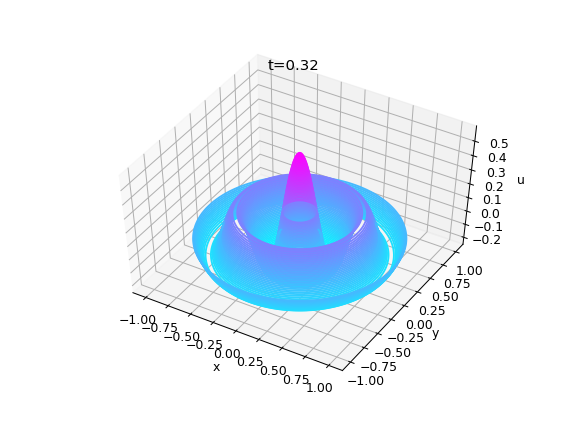

/usr/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [5]:
from scipy.special import j0, jn_zeros

c_true = 0.25
lambda4 = jn_zeros(0, 4)[-1]
u_fn = lambda x, y, t: np.select([x**2+y**2 > 1, x**2+y**2 <= 1], 
								 [0, j0(lambda4*np.sqrt(x**2+y**2))*np.cos(c_true*lambda4*t)])

x0 = np.linspace(-1, 1, 200)
y0 = np.linspace(-1, 1, 200)
t0 = 0.32
u0 = u_fn(x0, y0, t0)

from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

fig = plt.figure()
ax = plt.axes(projection='3d')
X, Y = np.meshgrid(x0, y0)
U = u_fn(X, Y, t0)
ax.contour3D(X, Y, U, 100, cmap='cool')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('u')
ax.set_title("t={}".format(t0))

plt.show()

In [7]:
@jax.jit
def mse(pred, true):
	return jnp.mean(jnp.square(pred - true))

@jax.jit
def l2_regularization(params, lambda_0):
	res = 0
	for p in params:
		res += jnp.sum(jnp.square(p[0]))
	return res*lambda_0

@jax.jit
def loss_fn_(params, batch):
	direct_params = params
	collocation, dirichlet, neumann = batch["collocation"], batch["dirichlet"], batch["neumann"]
	
	# jacobian[i]: [[du_dx, du_dy, du_dt]],
	du_dxyt_n = jacobian(direct_params, jnp.hstack([neumann.x, neumann.y, neumann.t]))
	du_dt_n = du_dxyt_n[:, 0, 2:3]
    
	# hessian[i]: [[[du_dxx, du_dxy, du_dxt],
	#              [du_dxy, du_dyy, du_dyt],
	#              [du_dxt, du_dyt, du_dtt]]]
	du_dxxyytt = hessian(direct_params, jnp.hstack([collocation.x, collocation.y, collocation.t]))
	du_dxx_c, du_dyy_c, du_dtt_c = du_dxxyytt[:, 0, 0:1, 0], du_dxxyytt[:, 0, 1:2, 1], du_dxxyytt[:, 0, 2:3, 2]

	u_d = direct_model(direct_params, jnp.hstack([dirichlet.x, dirichlet.y, dirichlet.t]))
	
	loss_c = mse(du_dtt_c - c_true**2*(du_dxx_c + du_dyy_c), 0)
	loss_d = mse(u_d, dirichlet.u)
	loss_n = mse(du_dt_n, neumann.v)
	return loss_c, loss_d, loss_n

@jax.jit
def loss_fn(params, batch):
	loss_c, loss_d, loss_n = loss_fn_(params, batch)
	return batch["weights"]["c"]*loss_c + batch["weights"]["d"]*loss_d + batch["weights"]["n"]*loss_n + l2_regularization(params[0], lambda_0)

@jax.jit
def step(i, opt_state, batch):
	params = get_params(opt_state)
	grad = jax.grad(loss_fn, 0)(params, batch)
	return opt_update(i, grad, opt_state)

@jax.jit
def evaluate(params, batch):
	loss_c, loss_d, loss_n = loss_fn_(params, batch)
	return batch["weights"]["c"]*loss_c + batch["weights"]["d"]*loss_d + batch["weights"]["n"]*loss_n, loss_c, loss_d, loss_n


# @jax.jit
# def mse(pred, true):
# 	return jnp.mean(jnp.square(pred - true))

# @jax.jit
# def l2_regularization(params, lambda_0):
# 	res = 0
# 	for p in params:
# 		res += jnp.sum(jnp.square(p[0]))
# 	return res*lambda_0

# @jax.jit
# def scalar_du_dx(params, x, y, t):
#     return jnp.sum(jax.grad(scalar_direct_model, 1)(params, x, y, t))

# @jax.jit
# def scalar_du_dy(params, x, y, t):
#     return jnp.sum(jax.grad(scalar_direct_model, 2)(params, x, y, t))

# @jax.jit
# def scalar_du_dt(params, x, y, t):
#     return jnp.sum(jax.grad(scalar_direct_model, 3)(params, x, y, t))

# du_dt = jax.jit(jax.vmap(scalar_du_dt, in_axes = (None, 0, 0, 0)))

# @jax.jit
# def du_dxx(params, x, y, t):
#     return jax.grad(scalar_du_dx, 1)(params, x, y, t)

# @jax.jit
# def du_dyy(params, x, y, t):
#     return jax.grad(scalar_du_dy, 2)(params, x, y, t)

# @jax.jit
# def du_dtt(params, x, y, t):
#     return jax.grad(scalar_du_dt, 3)(params, x, y, t)

# @jax.jit
# def loss_fn_(params, batch):
# 	direct_params = params
# 	collocation, dirichlet, neumann = batch["collocation"], batch["dirichlet"], batch["neumann"]
    
# 	du_dt_ = du_dt(direct_params, neumann.x, neumann.y, neumann.t)
	
# 	du_dtt_ = du_dtt(direct_params, collocation.x, collocation.y, collocation.t)
# 	du_dxx_ = du_dxx(direct_params, collocation.x, collocation.y, collocation.t)
# 	du_dyy_ = du_dyy(direct_params, collocation.x, collocation.y, collocation.t)
# 	u_pred = direct_model(direct_params, dirichlet.x, dirichlet.y, dirichlet.t).reshape((-1, 1))
	
# 	loss_c = mse(du_dtt_ - c_true**2*(du_dxx_ + du_dyy_), 0)
# 	loss_d = mse(u_pred, dirichlet.u)
# 	loss_n = mse(du_dt_, neumann.v)
# 	return loss_c, loss_d, loss_n

# @jax.jit
# def loss_fn(params, batch):
# 	loss_c, loss_d, loss_n = loss_fn_(params, batch)
# 	return batch["weights"]["c"]*loss_c + batch["weights"]["d"]*loss_d + batch["weights"]["n"]*loss_n + l2_regularization(params[0], lambda_0)

# @jax.jit
# def step(i, opt_state, batch):
# 	params = get_params(opt_state)
# 	grad = jax.grad(loss_fn, 0)(params, batch)
# 	return opt_update(i, grad, opt_state)

# @jax.jit
# def evaluate(params, batch):
# 	loss_c, loss_d, loss_n = loss_fn_(params, batch)
# 	return batch["weights"]["c"]*loss_c + batch["weights"]["d"]*loss_d + batch["weights"]["n"]*loss_n, loss_c, loss_d, loss_n

In [8]:
key = random.PRNGKey(1)
T_max = 1

# ic
key, *subkeys = random.split(key, 4)
n_i = 20000
r_i = random.uniform(subkeys[0], (n_i, 1), np.float32, minval = 0, maxval = 1.0)
theta_i = random.uniform(subkeys[1], (n_i, 1), np.float32, minval = 0, maxval = 2*np.pi)
t_i = jnp.zeros_like(r_i)
x_i = r_i*jnp.cos(theta_i)
y_i = r_i*jnp.sin(theta_i)
u_i = u_fn(x_i, y_i, t_i)
v_i = jnp.zeros_like(r_i)

# bc
key, *subkeys = random.split(key, 4)
n_b = 20000
theta_b = random.uniform(subkeys[1], (n_b, 1), np.float32, minval = 0, maxval = 2*np.pi)
r_b = jnp.ones_like(theta_b)
t_b = random.uniform(subkeys[2], (n_b, 1), np.float32, minval = 0, maxval = T_max)
x_b = r_b*jnp.cos(theta_b)
y_b = r_b*jnp.sin(theta_b)
u_b = u_fn(x_b, y_b, t_b)

# c
key, *subkeys = random.split(key, 4)
n_c = 100000
r_c = random.uniform(subkeys[0], (n_c, 1), np.float32, minval = 0, maxval = 1.0)
theta_c = random.uniform(subkeys[1], (n_c, 1), np.float32, minval = 0, maxval = 2*np.pi)
t_c = random.uniform(subkeys[2], (n_c, 1), np.float32, minval = 0, maxval = T_max)
x_c = r_c*jnp.cos(theta_c)
y_c = r_c*jnp.sin(theta_c)

dataset_Dirichlet = namedtuple("dataset_Dirichlet", ["x", "y", "t", "u"])
dataset_Collocation = namedtuple("dataset_Collocation", ["x", "y", "t"])
dataset_Neumann = namedtuple("dataset_Neumann", ["x", "y", "t", "v"])
dirichlet = dataset_Dirichlet(*map(lambda x: jnp.array(x), [jnp.vstack([x_i, x_b]), 
															jnp.vstack([y_i, y_b]),
															jnp.vstack([t_i, t_b]),
															jnp.vstack([u_i, u_b])]))
collocation = dataset_Collocation(*map(lambda x: jnp.array(x), [jnp.vstack([x_c, dirichlet.x]),
																jnp.vstack([y_c, dirichlet.y]), 
																jnp.vstack([t_c, dirichlet.t])]))
neumann = dataset_Neumann(*map(lambda x: jnp.array(x), [x_i, y_i, t_i, v_i]))

class Batch_Generator:
	def __init__(self, key, dataset, batch_size):
		self.key = key
		self.dataset = dataset
		self.batch_size = batch_size
		self.index = jnp.arange(dataset[0].shape[0])
		self.pointer = 0
		self._shuffle()
		
	def _shuffle(self):
		key, subkey = random.split(self.key)
		self.index = random.permutation(subkey, jnp.arange(self.dataset[0].shape[0]))
		self.key = key
		
	def __iter__(self):
		return self
	
	def __next__(self):
		if self.pointer >= len(self.index):
			self._shuffle()
			self.pointer = 0
		self.pointer += self.batch_size
		index_ = self.index[self.pointer-self.batch_size:self.pointer]
		return [d[index_, :] for d in self.dataset]

In [7]:
lr = 1e-3
start_iteration = 0
iterations = 50000
print_every = 200
save_every = 50000
batch_size = {"collocation": 10000, "dirichlet": 10000, "neumann": 10000}
weights = {"c": 1.0, "d": 100.0, "n": 10.0}

key, *subkeys = random.split(key, 4)
Dirichlet = Batch_Generator(subkeys[0], dirichlet, batch_size["dirichlet"])
Collocation = Batch_Generator(subkeys[1], collocation, batch_size["collocation"])
Neumann = Batch_Generator(subkeys[2], neumann, batch_size["neumann"])

opt_init, opt_update, get_params = optimizers.adam(lr)
opt_state = opt_init(direct_params)
for iteration in range(start_iteration+1, start_iteration+iterations+1):
	batch = {
		"dirichlet": dataset_Dirichlet(*next(Dirichlet)),
		"collocation": dataset_Collocation(*next(Collocation)),
		"neumann": dataset_Neumann(*next(Neumann)),
		"weights": weights
	}
	opt_state = step(iteration, opt_state, batch)
	if (iteration-start_iteration) % print_every == 0:
		names = ["Loss", "c", "d", "n"]
		params_ = get_params(opt_state)
		losses = evaluate(params_, batch)
		print("{}, Iteration: {}, Train".format(get_time(), iteration) + \
			  ','.join([" {}: {:.4e}".format(name, loss) for name, loss in zip(names, losses)]))
	if (iteration-start_iteration) % save_every == 0:
		params_ = np.asarray(get_params(opt_state), dtype = object)
		save_path = "models/{}/iteration_{}/params.npy".format(NAME, iteration)
		if not os.path.exists(os.path.dirname(save_path)):
			os.makedirs(os.path.dirname(save_path))
		np.save(save_path, params_)

2020/08/02, 16:54:24, Iteration: 200, Train Loss: 3.7501e+00, c: 2.5974e-01, d: 3.4426e-02, n: 4.7701e-03
2020/08/02, 16:54:27, Iteration: 400, Train Loss: 2.7544e+00, c: 4.0864e-01, d: 2.3103e-02, n: 3.5406e-03
2020/08/02, 16:54:30, Iteration: 600, Train Loss: 2.3926e+00, c: 3.4564e-01, d: 2.0324e-02, n: 1.4595e-03
2020/08/02, 16:54:33, Iteration: 800, Train Loss: 2.3144e+00, c: 3.2058e-01, d: 1.9786e-02, n: 1.5260e-03
2020/08/02, 16:54:36, Iteration: 1000, Train Loss: 2.1301e+00, c: 2.6029e-01, d: 1.8528e-02, n: 1.7000e-03
2020/08/02, 16:54:39, Iteration: 1200, Train Loss: 1.8920e+00, c: 2.0184e-01, d: 1.6731e-02, n: 1.7020e-03
2020/08/02, 16:54:42, Iteration: 1400, Train Loss: 1.7865e+00, c: 1.7588e-01, d: 1.5947e-02, n: 1.5899e-03
2020/08/02, 16:54:45, Iteration: 1600, Train Loss: 1.7432e+00, c: 1.6494e-01, d: 1.5580e-02, n: 2.0212e-03
2020/08/02, 16:54:48, Iteration: 1800, Train Loss: 1.4070e+00, c: 1.6445e-01, d: 1.2198e-02, n: 2.2694e-03
2020/08/02, 16:54:51, Iteration: 2000, Tr

2020/08/02, 16:58:15, Iteration: 15600, Train Loss: 1.3390e-01, c: 7.1832e-02, d: 5.5982e-04, n: 6.0893e-04
2020/08/02, 16:58:18, Iteration: 15800, Train Loss: 1.6820e-01, c: 7.1156e-02, d: 8.9060e-04, n: 7.9873e-04
2020/08/02, 16:58:21, Iteration: 16000, Train Loss: 1.1882e-01, c: 7.0765e-02, d: 4.2192e-04, n: 5.8601e-04
2020/08/02, 16:58:24, Iteration: 16200, Train Loss: 1.0516e-01, c: 6.9553e-02, d: 3.0117e-04, n: 5.4882e-04
2020/08/02, 16:58:27, Iteration: 16400, Train Loss: 1.1749e-01, c: 6.7997e-02, d: 4.3932e-04, n: 5.5589e-04
2020/08/02, 16:58:30, Iteration: 16600, Train Loss: 1.1008e-01, c: 6.6199e-02, d: 3.8352e-04, n: 5.5327e-04
2020/08/02, 16:58:33, Iteration: 16800, Train Loss: 1.0307e-01, c: 6.5667e-02, d: 3.2181e-04, n: 5.2270e-04
2020/08/02, 16:58:36, Iteration: 17000, Train Loss: 9.8331e-02, c: 6.3079e-02, d: 2.9768e-04, n: 5.4837e-04
2020/08/02, 16:58:39, Iteration: 17200, Train Loss: 1.1377e-01, c: 6.5203e-02, d: 4.3153e-04, n: 5.4128e-04
2020/08/02, 16:58:42, Iterat

2020/08/02, 17:02:05, Iteration: 30800, Train Loss: 1.5687e-02, c: 4.1409e-03, d: 1.0165e-04, n: 1.3813e-04
2020/08/02, 17:02:08, Iteration: 31000, Train Loss: 1.4536e-02, c: 4.1912e-03, d: 8.8104e-05, n: 1.5343e-04
2020/08/02, 17:02:11, Iteration: 31200, Train Loss: 8.4315e-03, c: 3.7999e-03, d: 3.7980e-05, n: 8.3354e-05
2020/08/02, 17:02:14, Iteration: 31400, Train Loss: 8.7212e-03, c: 3.9614e-03, d: 3.7443e-05, n: 1.0155e-04
2020/08/02, 17:02:17, Iteration: 31600, Train Loss: 1.2087e-02, c: 3.8574e-03, d: 7.1290e-05, n: 1.1009e-04
2020/08/02, 17:02:20, Iteration: 31800, Train Loss: 7.7512e-03, c: 3.7276e-03, d: 3.2309e-05, n: 7.9268e-05
2020/08/02, 17:02:23, Iteration: 32000, Train Loss: 6.4327e-03, c: 3.5498e-03, d: 2.1227e-05, n: 7.6028e-05
2020/08/02, 17:02:26, Iteration: 32200, Train Loss: 9.4585e-03, c: 3.7445e-03, d: 4.8695e-05, n: 8.4454e-05
2020/08/02, 17:02:29, Iteration: 32400, Train Loss: 1.9294e-02, c: 3.9712e-03, d: 1.4245e-04, n: 1.0772e-04
2020/08/02, 17:02:32, Iterat

2020/08/02, 17:05:53, Iteration: 46000, Train Loss: 8.7632e-03, c: 1.6310e-03, d: 6.7432e-05, n: 3.8900e-05
2020/08/02, 17:05:56, Iteration: 46200, Train Loss: 4.4719e-03, c: 1.5085e-03, d: 2.4955e-05, n: 4.6792e-05
2020/08/02, 17:05:59, Iteration: 46400, Train Loss: 6.5768e-03, c: 1.5438e-03, d: 4.5494e-05, n: 4.8373e-05
2020/08/02, 17:06:02, Iteration: 46600, Train Loss: 6.4881e-03, c: 1.5209e-03, d: 4.5375e-05, n: 4.2973e-05
2020/08/02, 17:06:05, Iteration: 46800, Train Loss: 2.6969e-03, c: 1.3981e-03, d: 9.9815e-06, n: 3.0064e-05
2020/08/02, 17:06:08, Iteration: 47000, Train Loss: 3.0747e-03, c: 1.4577e-03, d: 1.2615e-05, n: 3.5547e-05
2020/08/02, 17:06:11, Iteration: 47200, Train Loss: 3.2835e-03, c: 1.4086e-03, d: 1.5099e-05, n: 3.6503e-05
2020/08/02, 17:06:14, Iteration: 47400, Train Loss: 4.0739e-03, c: 1.4503e-03, d: 2.2654e-05, n: 3.5820e-05
2020/08/02, 17:06:17, Iteration: 47600, Train Loss: 6.4919e-03, c: 1.4420e-03, d: 4.6683e-05, n: 3.8155e-05
2020/08/02, 17:06:20, Iterat

In [9]:
iteration = 50000
direct_params = np.load("models/{}/iteration_{}/params.npy".format(NAME, iteration), allow_pickle=True)
direct_params = [[jnp.asarray(arr) for arr in Arr] for Arr in direct_params]

<IPython.core.display.Javascript object>


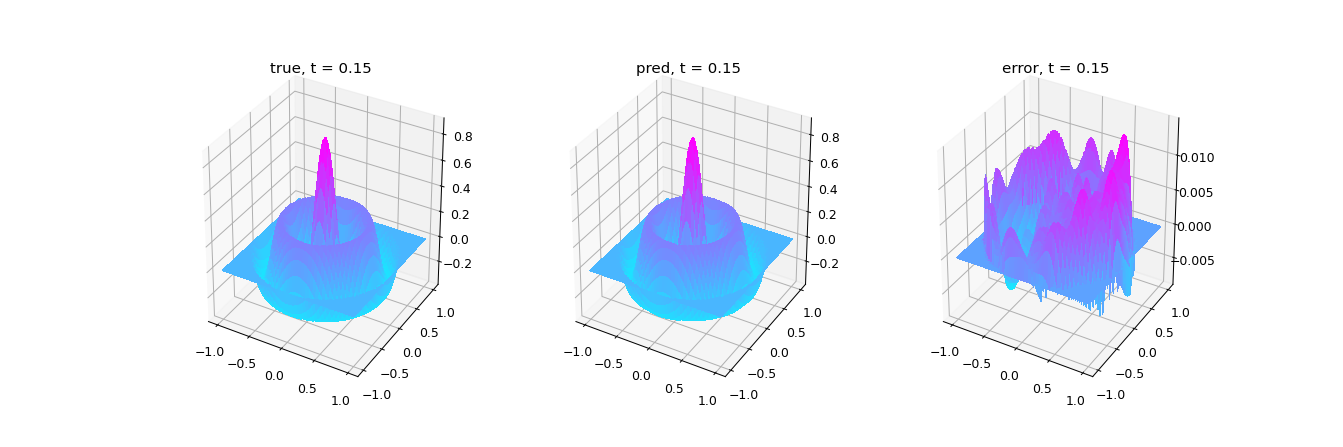

In [14]:
from matplotlib import animation
%matplotlib notebook

x_test = np.linspace(-1, 1, 100)
y_test = np.linspace(-1, 1, 100)
t_test = np.linspace(0, 1, 100)
X, Y = np.meshgrid(x_test, y_test)

xyt_tests = [jnp.array(tensor_grid([x_test, y_test, ti])) for ti in t_test]
u_preds = [np.array(direct_model(direct_params, xyt).reshape((len(x_test), len(y_test)))) for xyt in xyt_tests]
zero_ix_ = np.where(X**2+Y**2 > 1)
for u_pred in u_preds:
	u_pred[zero_ix_] = 0

u_trues = [u_fn(xyt[:, 0:1], xyt[:, 1:2], xyt[:, 2:3]).reshape(len(x_test), len(y_test)) for xyt in xyt_tests]

fig = plt.figure(figsize = (15, 5))
ax = []
for i in range(3):
	ax.append(fig.add_subplot(131+i, projection = "3d"))
	
contours = []

for i in range(3):
	surf = ax[i].plot_surface(X, Y, np.zeros_like(X), cmap = "cool")
	contours.append(surf)

def animate(i):
	global contours
	
	u_pred = u_preds[i]
	u_true = u_trues[i]
	u_err = u_pred - u_true
	
	for j in range(3):
		ax[j].clear()
		
	contours[0] = ax[0].plot_surface(X, Y, u_true, cmap = "cool", linewidth=0, antialiased=False)
	ax[0].set_title("true, t = {:.2f}".format(t_test[i]))
    
	contours[1] = ax[1].plot_surface(X, Y, u_pred, cmap = "cool", linewidth=0, antialiased=False)
	ax[1].set_title("pred, t = {:.2f}".format(t_test[i]))

	contours[2] = ax[2].plot_surface(X, Y, u_err, cmap = "cool", linewidth=0, antialiased=False)
	ax[2].set_title("error, t = {:.2f}".format(t_test[i]))

	return contours

anim = animation.FuncAnimation(fig, animate, frames = len(t_test), interval = 50, blit = True)
plt.show()

In [ ]:
t_index = 0
txy_test = tensor_grid([t_c[t_index], x_c, y_c])
u_pred = direct_model(direct_params, txy_test[:, 1:2], txy_test[:, 2:3], txy_test[:, 0:1]).reshape((n_c, n_c))
u_true = u_fn(txy_test[:, 1:2], txy_test[:, 2:3], txy_test[:, 0:1]).reshape((n_c, n_c))

import matplotlib as mpl
from matplotlib.cm import cool
from matplotlib.colors import Normalize

from mpl_toolkits.axes_grid1 import make_axes_locatable

from matplotlib import pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)

cmap = cool
norm = Normalize(vmin=0, vmax=0.5)

X, Y = np.meshgrid(x_c, y_c)
fig, ax = plt.subplots(1, 3, figsize = (15, 5))
fig.subplots_adjust(right = 1.0)

im0 = ax[0].contourf(X, Y, u_true, cmap = cmap, norm = norm, levels = 1000)
ax[0].set_title("true")
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
mpl.colorbar.ColorbarBase(cax, cmap = cmap, norm = norm, orientation='vertical')

# norm = mpl.colors.Normalize(vmin=1.0, vmax=3.0)
im1 = ax[1].contourf(X, Y, u_pred, cmap = cmap, norm = norm, levels = 1000)
ax[1].set_title("pred")
ax[1].set_xlabel("")
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
mpl.colorbar.ColorbarBase(cax, cmap = cmap, norm = norm, orientation='vertical')

norm = mpl.colors.Normalize(vmin=-0.2, vmax=0.2)
im2 = ax[2].contourf(X, Y, u_true - u_pred, cmap = cmap, norm = norm, levels = 1000)
ax[2].set_title("t = {:.4e}, MSE: {}".format(t_c[t_index], np.mean(np.square(u_true - u_pred))))
divider = make_axes_locatable(ax[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
mpl.colorbar.ColorbarBase(cax, cmap = cmap, norm = norm, orientation='vertical')

plt.show()